Importing the dataset and obtaining the biterms:

0 repositories will be removed due to having more than 250 tokens.
       LENGTH_PROCESSED
count       1059.000000
mean          12.495751
std            9.556356
min            3.000000
25%            6.000000
50%            9.000000
75%           16.000000
max          112.000000


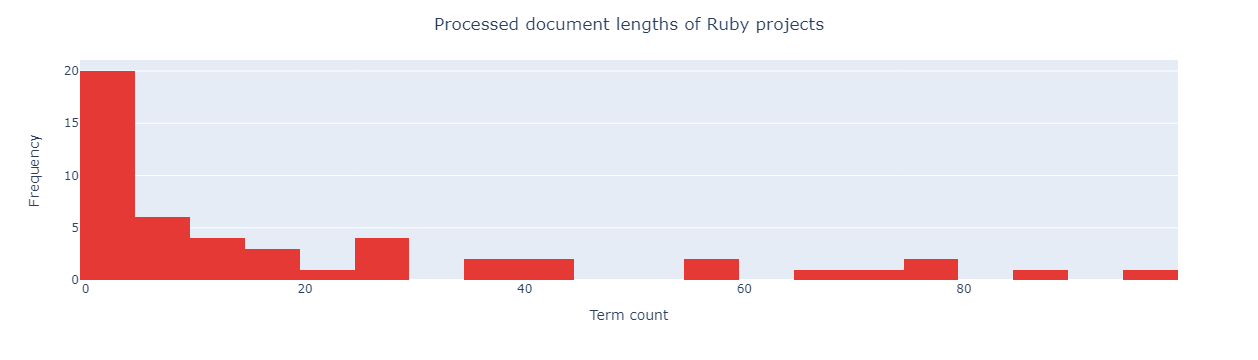

Vocabulary size: 71


In [152]:
import bitermplus as btm
import numpy as np
import pandas as pd
import statistics
import scipy.stats
import optuna
import plotly.express as px
import tqdm
import itertools
import tmplot as tmp

language = "Ruby"
max_token_limit = 250

language_colors = {"Go": "#00ACC1", "Java": "#6D4C41", "Python": "#43A047", "Ruby": "#E53935"}

def contexts_to_text(contexts):
    return " ".join([" ".join(context) + "." for context in eval(contexts)])

def count_total_terms(contexts):
    return sum([len(context) for context in eval(contexts)])

def get_top_topics_entropy(model, top_n):
    n_topic = model.matrix_topics_words_.shape[0]

    topic_entropies = {}
    for topic_id in range(n_topic):
        topic_entropy =  btm.entropy(np.array([model.matrix_topics_words_[topic_id]]))
        topic_entropies[topic_id] = topic_entropy

    topic_entropies = dict(sorted(topic_entropies.items(), key=lambda item: item[1], reverse=True))
    discarded_topics = list(topic_entropies.keys())[top_n:]
    top_topics_entropy = btm.entropy(np.delete(model.matrix_topics_words_, discarded_topics, axis=0))
    return top_topics_entropy

repos = pd.read_csv(f"processed_readmes_{language.lower()}.csv", sep=";", quotechar="'")

repos["TEXT_PROCESSED"] = repos["CONTEXTS"].transform(contexts_to_text)
repos["LENGTH_PROCESSED"] = repos["CONTEXTS"].transform(count_total_terms)

print(f"{repos[repos.LENGTH_PROCESSED > max_token_limit].shape[0]} repositories will be removed due to having more than {max_token_limit} tokens.")

# for id, row in repos.iterrows():
#     if row.LENGTH_PROCESSED > max_token_limit:
#         print(f"{row.OWNER}/{row.NAME}", row.LENGTH_PROCESSED)
#         print(row.TEXT_PROCESSED)
#         print("")

repos = repos[repos.LENGTH_PROCESSED <= max_token_limit]

print(repos.describe())

px.histogram(repos["LENGTH_PROCESSED"].value_counts(), nbins=30, width=600, height=300).update_traces(marker_color=language_colors[language]).update_layout(showlegend=False, title_text=f"Processed document lengths of {language} projects", title_x=0.5, yaxis_title="Frequency", xaxis_title="Term count").show()

texts = repos["TEXT_PROCESSED"]

language_removed_words = {"Go": ["go", "golang"], "Java": ["java"], "Python": ["python"], "Ruby": ["ruby"]}
# common_removed_words = ["library", "package"]
common_removed_words = []

X, vocabulary, vocab_dict = btm.get_words_freqs(texts, binary=False, stop_words=language_removed_words[language]+common_removed_words, min_df=0.02) # It can take whatever parameter CounterVectorizer can take: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
biterms = btm.get_biterms(docs_vec)

print("Vocabulary size:", len(vocabulary))

# vocab_dict

## Topic modeling

Hyperparameter optimization for topic modeling using the top-n topic entropy:

In [153]:
best_parameters = {
                   "Go": {"n_topic": 5, "alpha_multiplier": 4.418641550920036}, 
                   "Java": {"n_topic": 5, "alpha_multiplier": 4.886378432794765}, # entropy=2.2827251320259494
                   "Python": {"n_topic": 8, "alpha_multiplier": 41.64512461906446}, # entropy=2.295825851703303
                   "Ruby": {"n_topic": 5, "alpha_multiplier": 26.73802789246041} # entropy=2.3412844374509705
                  }

def objective(trial):
    n_topic = trial.suggest_int("n_topic", 5, 50, log=False)
    alpha_multiplier = trial.suggest_float("alpha_multiplier", 2, 50, log=False)
    # beta = trial.suggest_float("beta", 0.005, 0.02, log=True)
    # has_background = trial.suggest_categorical("has_background", [True, False])
    
    model = btm.BTM(X, vocabulary, seed=42, T=n_topic, M=5, alpha=1/(n_topic*alpha_multiplier), beta=0.01, has_background=False)
    model.fit(biterms, iterations=600, verbose=False)

    # return btm.entropy(model.matrix_topics_words_)
    return get_top_topics_entropy(model, 5)

if language not in best_parameters:
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_jobs=6, n_trials=100, show_progress_bar=True)

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    best_parameters[language] = {}
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        best_parameters[language][key] = value

In [154]:
model = btm.BTM(X, vocabulary, seed=42, T=best_parameters[language]["n_topic"], M=5, win=500, alpha=1/(best_parameters[language]["n_topic"]*best_parameters[language]["alpha_multiplier"]), beta=0.01, has_background=False)
model.fit(biterms, iterations=600)

coherences = np.exp(model.coherence_)

print("Model entropy (all topics):", btm.entropy(model.matrix_topics_words_))
print("Model entropy (top 5 topics):", get_top_topics_entropy(model, 5))
print("Perplexity:", model.perplexity_)
print("Coherence:", scipy.stats.describe(coherences))

100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 3351.91it/s]

Model entropy (all topics): 2.3412844374509705
Model entropy (top 5 topics): 2.3412844374509705
Perplexity: 7.166423472110015e+303
Coherence: DescribeResult(nobs=5, minmax=(1.0886016560779912e-11, 5.75883919978561e-09), mean=1.7305279240821285e-09, variance=6.3724668344540675e-18, skewness=0.9102461385788618, kurtosis=-0.788460922540509)


Displaying the top 5 topics:

Stable topics: [2, 3]


100%|███████████████████████████████████████████████████████████████████████████| 1059/1059 [00:00<00:00, 99388.42it/s]


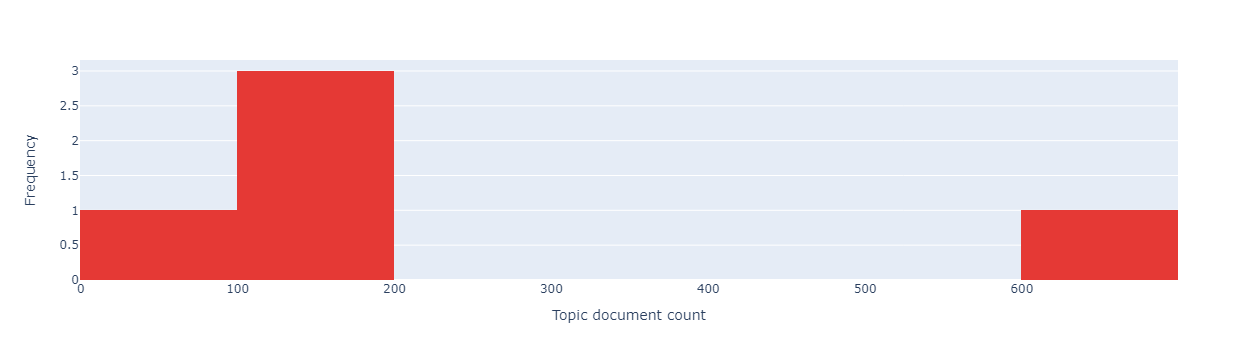

[4, 0, 3, 1, 2]


,topic4,topic0,topic3,topic1,topic2
0,use,test,api,use,support
1,gem,use,client,library,library
2,rail,code,library,gem,officially
3,project,file,service,provide,following
4,support,tool,support,model,project
5,make,run,gem,object,please
6,add,create,request,file,use
7,provide,simple,web,generate,base
8,need,write,provide,simple,framework
9,code,command,official,user,feature


Document counts by topic and some examples:
Topic 4: 621 repos


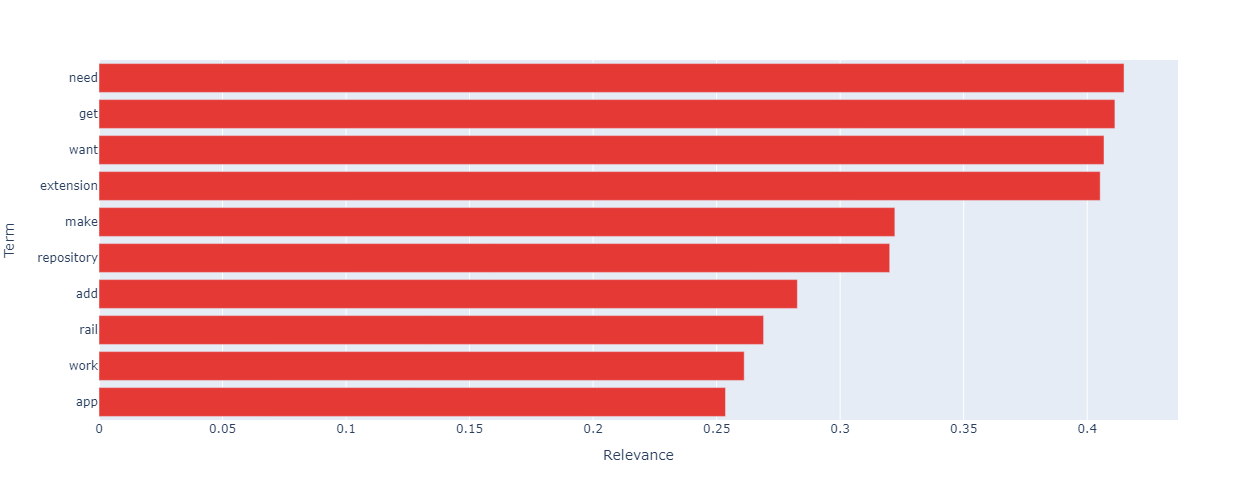

Top 10 documents:


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,LENGTH_PROCESSED,TOPIC
20,ahoward,map,"[[""synopsis"", ""awesome"", ""ruby"", ""container"", ...",synopsis awesome ruby container always want st...,13,4
105,braintree,pg_ha_migrations,"[[""document"", ""learned"", ""best"", ""practice"", ""...",document learned best practice apply schema ch...,30,4
173,copiousfreetime,amalgalite,"[[""amalgalite"", ""embed"", ""sqlite"", ""database"",...",amalgalite embed sqlite database engine ruby e...,11,4
411,instructure,switchman,"[[""switchman"", ""activerecord"", ""extension"", ""s...",switchman activerecord extension sharding data...,8,4
418,ITV,aws-assume-role,"[[""aws-assume-role"", ""utility"", ""intend"", ""dev...",aws-assume-role utility intend developer opera...,14,4
555,mgomes,api_auth,"[[""logins"", ""password"", ""human"", ""communicatio...",logins password human communication applicatio...,9,4
567,mirego,activerecord_json_validator,"[[""activerecord"", ""jsonvalidator"", ""make"", ""ea...",activerecord jsonvalidator make easy validate ...,9,4
588,mruby-esp32,mruby-esp32,"[[""get"", ""start"", ""need"", ""follow"", ""setup"", ""...",get start need follow setup documentation esp-...,11,4
592,mxenabled,action_subscriber,"[[""actionsubscriber"", ""dsl"", ""easily"", ""interg...",actionsubscriber dsl easily intergrating rail ...,9,4
1029,xijo,reverse_markdown,"[[""transform"", ""html"", ""markdown"", ""useful"", ""...",transform html markdown useful example want im...,11,4


synopsis awesome ruby container always want string symbol indifferent order hash work ruby.
document learned best practice apply schema change without downtime post postgresql scale database schema change without downtime paypal technology blog many approach take choice make explain much great depth readme.
amalgalite embed sqlite database engine ruby extension need_NEG install_NEG sqlite_NEG separately_NEG.
switchman activerecord extension sharding database key feature include.
aws-assume-role utility intend developer operator environment need use 2fa role assumption access aws service.
logins password human communication application need protect different mean.
activerecord jsonvalidator make easy validate json attribute json schema.
get start need follow setup documentation esp-idf project specific operating system.
actionsubscriber dsl easily intergrating rail app rabbitmq message server.
transform html markdown useful example want import html markdown base application.
Topic 0: 19

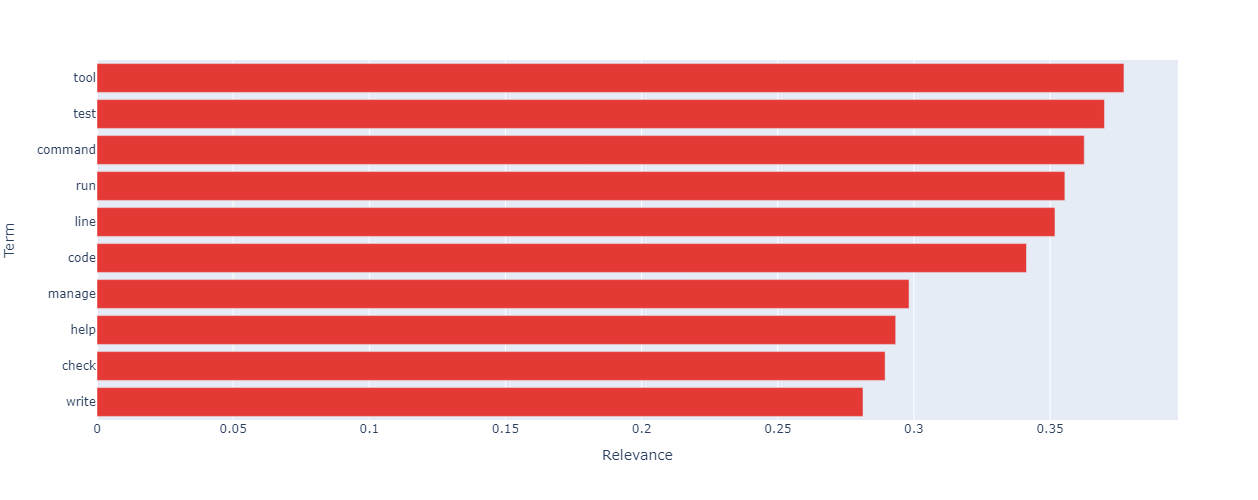

Top 10 documents:


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,LENGTH_PROCESSED,TOPIC
287,floraison,fugit,"[[""time"", ""tool"", ""flor"", ""floraison"", ""group""]]",time tool flor floraison group.,5,0
371,hercules-team,augeas,"[[""augeas"", ""library"", ""command"", ""line"", ""too...",augeas library command line tool focus basic p...,18,0
451,joenorton,rubyretriever,"[[""rubyretriever"", ""web"", ""crawler"", ""scraper""...",rubyretriever web crawler scraper file harvest...,11,0
568,mizzy,serverspec,"[[""rspec"", ""test"", ""server"", ""configure"", ""pup...",rspec test server configure puppet chef anythi...,8,0
667,plataformatec,faraday-http-cache,"[[""faraday"", ""middleware"", ""respect"", ""http"", ...",faraday middleware respect http cache check ex...,10,0
689,puppetlabs,vmfloaty,"[[""cli"", ""helper"", ""tool"", ""puppet's"", ""vmpool...",cli helper tool puppet's vmpooler help stay af...,8,0
695,qrush,m,"[[""stand"", ""metal"", ""good"", ""test"", ""unit"", ""m...",stand metal good test unit minitest test runne...,12,0
813,sds,slim-lint,"[[""slim-lint"", ""tool"", ""help"", ""keep"", ""slim"",...",slim-lint tool help keep slim file clean reada...,21,0
965,travis-ci,kubernetes-config,"[[""travis"", ""service"", ""run"", ""kubernetes""]]",travis service run kubernetes.,4,0
992,vcr,vcr,"[[""record"", ""test"", ""suite's"", ""http"", ""intera...",record test suite's http interaction replay fu...,13,0


time tool flor floraison group.
augeas library command line tool focus basic problem handle linux configuration programmatically edit actual configuration file controlled manner.
rubyretriever web crawler scraper file harvester available command-line executable crawling framework.
rspec test server configure puppet chef anything else.
faraday middleware respect http cache check expiration validation stored response.
cli helper tool puppet's vmpooler help stay afloat.
stand metal good test unit minitest test runner run test line number.
slim-lint tool help keep slim file clean readable addition style lint check integrate rubocop bring powerful static analysis tool slim template.
travis service run kubernetes.
record test suite's http interaction replay future test run fast deterministic accurate test.
Topic 3: 114 repos


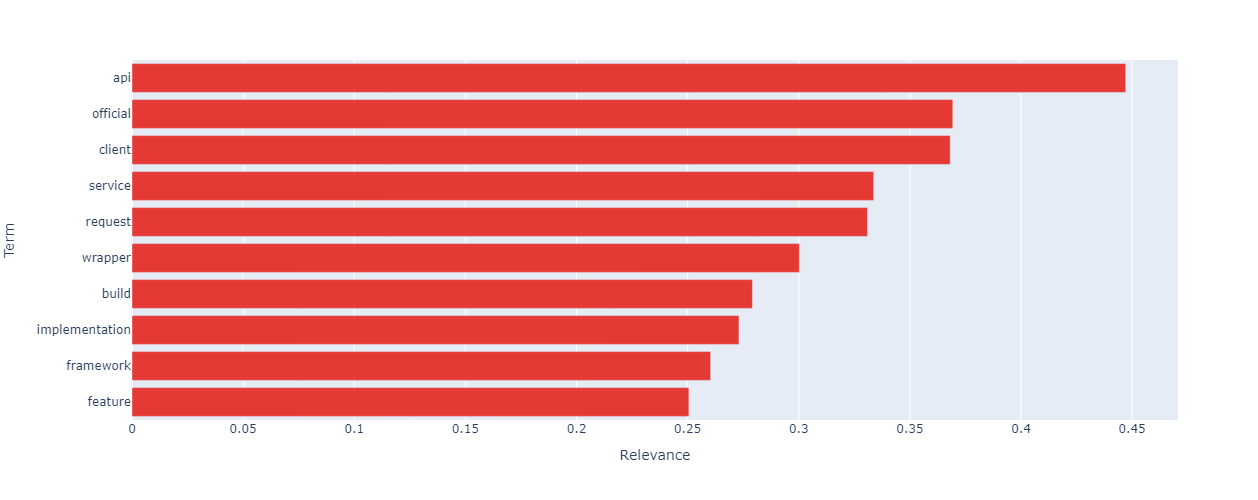

Top 10 documents:


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,LENGTH_PROCESSED,TOPIC
3,3scale,3scale_ws_api_for_ruby,"[[""3scale"", ""api"", ""infrastructure"", ""service""...",3scale api infrastructure service handle api k...,25,3
81,basecrm,basecrm-ruby,"[[""basecrm"", ""official"", ""api"", ""v2"", ""library...",basecrm official api v2 library client ruby.,7,3
123,cburnette,boxr,"[[""boxr"", ""ruby"", ""client"", ""library"", ""box"", ...",boxr ruby client library box v2 content api bo...,18,3
220,dnsimple,dnsimple-ruby,"[[""ruby"", ""client"", ""dnsimple"", ""api"", ""v2""]]",ruby client dnsimple api v2.,5,3
364,hashicorp,vault-ruby,"[[""vault"", ""official"", ""ruby"", ""client"", ""inte...",vault official ruby client interact vault hash...,7,3
406,influxdata,influxdb-ruby,"[[""official"", ""ruby"", ""client"", ""library"", ""in...",official ruby client library influxdb maintain...,8,3
491,kontena,kong-client-ruby,"[[""kong"", ""api"", ""client"", ""ruby""]]",kong api client ruby.,4,3
959,tpitale,staccato,"[[""ruby"", ""library"", ""track"", ""official"", ""goo...",ruby library track official google analytics m...,8,3
982,unixcharles,acme-client,"[[""acme-client"", ""client"", ""implementation"", ""...",acme-client client implementation acmev rfc pr...,7,3
983,Unleash,unleash-client-ruby,"[[""unleash"", ""client"", ""roll"", ""feature"", ""con...",unleash client roll feature confidence.,5,3


3scale api infrastructure service handle api key rate limiting analytics bill payment developer management include configurable api dashboard developer portal cm product stuff support information.
basecrm official api v2 library client ruby.
boxr ruby client library box v2 content api box employee affectionately refer one another boxer hence name gem.
ruby client dnsimple api v2.
vault official ruby client interact vault hashicorp.
official ruby client library influxdb maintain @toddboom @dmke.
kong api client ruby.
ruby library track official google analytics measurement protocol.
acme-client client implementation acmev rfc protocol ruby.
unleash client roll feature confidence.
Topic 1: 100 repos


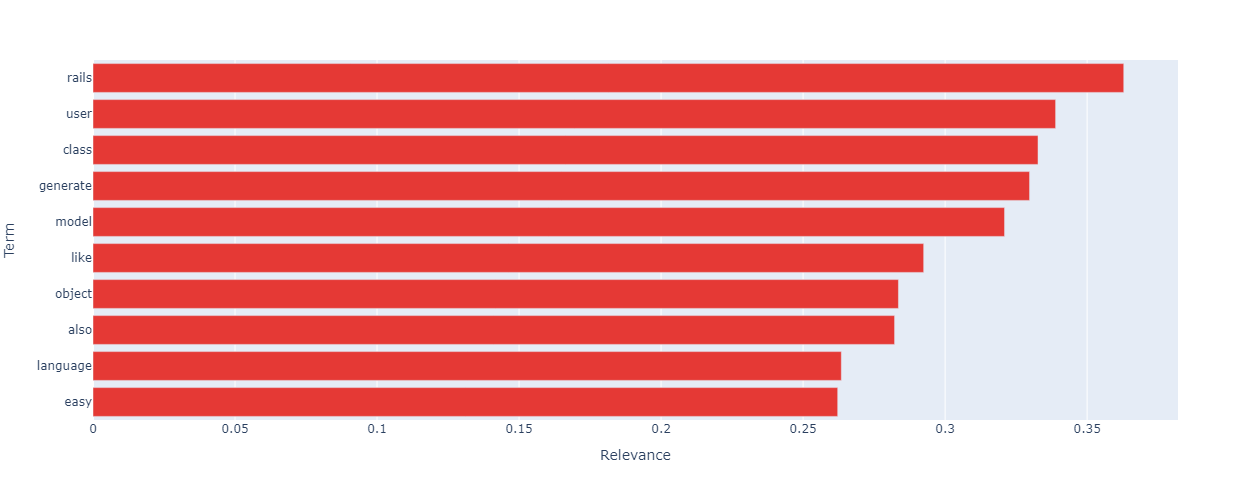

Top 10 documents:


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,LENGTH_PROCESSED,TOPIC
35,amoeba-rb,amoeba,"[[""easy"", ""cloning"", ""active_record"", ""object""...",easy cloning active_record object include asso...,10,1
67,asenchi,scrolls,"[[""scroll"", ""library"", ""generate"", ""log"", ""str...",scroll library generate log structure key value.,7,1
167,comma-csv,comma,"[[""library"", ""generate"", ""comma"", ""seperated"",...",library generate comma seperated value csv rub...,11,1
184,cvent,octopus-deploy-cookbook,"[[""cookbook"", ""use"", ""instal"", ""octopus"", ""dep...",cookbook use instal octopus deploy server tent...,10,1
289,fluent-plugins-nursery,fluent-plugin-out-http,"[[""generic"", ""fluentd"", ""output"", ""plugin"", ""s...",generic fluentd output plugin send log http en...,8,1
317,GetStream,stream-rails,"[[""stream-rails"", ""ruby"", ""rail"", ""client"", ""s...",stream-rails ruby rail client stream.,5,1
422,jackc,tod,"[[""supply"", ""timeofday"", ""class"", ""include"", ""...",supply timeofday class include parsing strftim...,8,1
617,oivoodoo,devise_masquerade,"[[""utility"", ""library"", ""enable"", ""functionall...",utility library enable functionallity like log...,8,1
960,trailblazer,reform-rails,"[[""load"", ""rails-specific"", ""reform"", ""file"", ...",load rails-specific reform file include module...,11,1
1015,wildbit,postmark-gem,"[[""postmark"", ""allow"", ""send"", ""email"", ""high""...",postmark allow send email high delivery rate a...,19,1


easy cloning active_record object include association several operation association attribute.
scroll library generate log structure key value.
library generate comma seperated value csv ruby object like activerecord array.
cookbook use instal octopus deploy server tentacle microsoft window machine.
generic fluentd output plugin send log http endpoint.
stream-rails ruby rail client stream.
supply timeofday class include parsing strftime comparison arithmetic.
utility library enable functionallity like login button admin.
load rails-specific reform file include module like reform form activemodel automatically.
postmark allow send email high delivery rate also include detailed statistic addition postmark parse incoming email forward back application.
Topic 2: 27 repos


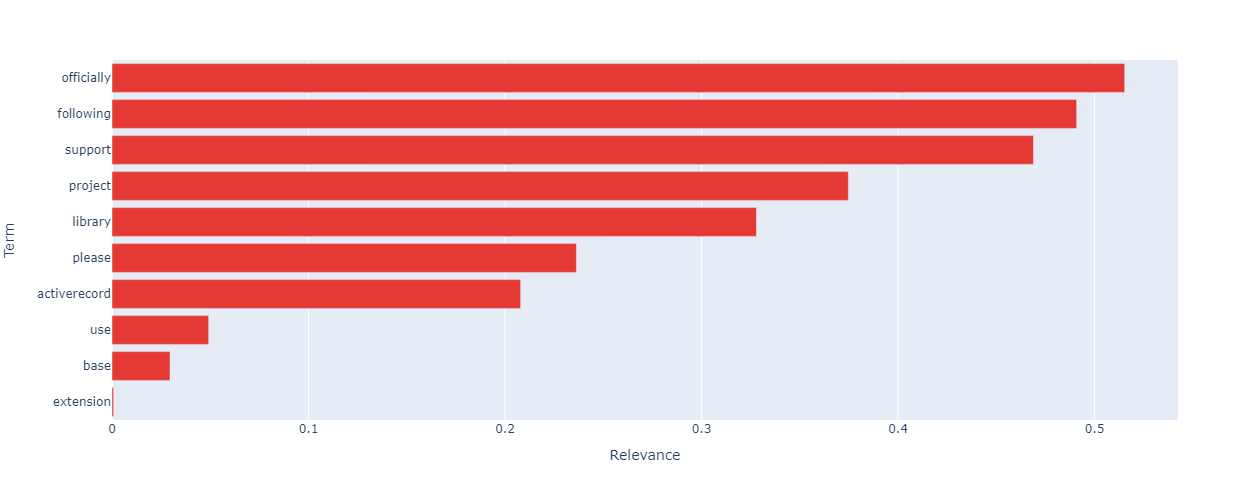

Top 10 documents:


,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,LENGTH_PROCESSED,TOPIC
163,collectiveidea,delayed_job_mongoid,"[[""delay"", ""job"", ""mongoid"", ""support"", ""follo...",delay job mongoid support following dependency...,7,2
228,dry-rb,dry-auto_inject,"[[""library"", ""officially"", ""support"", ""followi...",library officially support following ruby vers...,6,2
229,dry-rb,dry-configurable,"[[""library"", ""officially"", ""support"", ""followi...",library officially support following ruby vers...,6,2
230,dry-rb,dry-container,"[[""library"", ""officially"", ""support"", ""followi...",library officially support following ruby vers...,6,2
231,dry-rb,dry-core,"[[""library"", ""officially"", ""support"", ""followi...",library officially support following ruby vers...,6,2
232,dry-rb,dry-effects,"[[""library"", ""officially"", ""support"", ""followi...",library officially support following ruby vers...,6,2
233,dry-rb,dry-initializer,"[[""library"", ""officially"", ""support"", ""followi...",library officially support following ruby vers...,6,2
234,dry-rb,dry-logic,"[[""library"", ""officially"", ""support"", ""followi...",library officially support following ruby vers...,6,2
235,dry-rb,dry-matcher,"[[""library"", ""officially"", ""support"", ""followi...",library officially support following ruby vers...,6,2
236,dry-rb,dry-monads,"[[""library"", ""officially"", ""support"", ""followi...",library officially support following ruby vers...,6,2


delay job mongoid support following dependency version.
library officially support following ruby version.
library officially support following ruby version.
library officially support following ruby version.
library officially support following ruby version.
library officially support following ruby version.
library officially support following ruby version.
library officially support following ruby version.
library officially support following ruby version.
library officially support following ruby version.


In [155]:
mean_coherence = statistics.mean(coherences)    

stable_topics = []
for topic_id, topic_coherence in enumerate(coherences):
    if topic_coherence >= mean_coherence:
    # if topic_coherence > 0:
        stable_topics.append(topic_id)
        
print("Stable topics:", stable_topics)

def classify_doc(likelihoods, stable_topics=None):
    if stable_topics is None:
        stable_topics = list(range(0, likelihoods.shape[0]))
    filtered_max = max([likelihood for topic_id, likelihood in enumerate(likelihoods) if topic_id in stable_topics])
    return np.where(likelihoods == filtered_max)[0][0]

def get_top_n_topics(topic_doc_counts, n):
    top_n = sorted(topic_doc_counts.items(), key=lambda x: x[1], reverse=True)[:n]
    return [topic[0] for topic in top_n]

def get_top_n_terms(model, topic_id, n, lambda_=0.6, return_df=True, plot=True, show_title=True):
    phi = tmp.get_phi(model)
    terms_probs = tmp.calc_terms_probs_ratio(phi, topic=topic_id, lambda_=lambda_)
    terms_probs

    term_relevances = {}
    for term in terms_probs.Terms.unique():
        # marginal_prob = terms_probs[(terms_probs.Terms == term) & (terms_probs.Type == "Marginal term probability, p(w)")]["Probability"].values[0]
        # conditional_prob = terms_probs[(terms_probs.Terms == term) & (terms_probs.Type == "Conditional term probability, p(w|t)")]["Probability"].values[0]
        
        conditional_prob = phi.loc[term, topic_id] / phi[topic_id].sum()
        marginal_prob = phi.loc[term, topic_id] / phi.loc[term,].sum()
        
        term_relevances[term] = conditional_prob * lambda_ + marginal_prob * (1-lambda_)
    term_relevances = dict(sorted(term_relevances.items(), key=lambda x: x[1], reverse=True))
    top_terms = dict(itertools.islice(term_relevances.items(), n))
    top_terms = pd.DataFrame(top_terms.items(), columns=["Term", "Relevance"])
    
    if plot:
        fig = px.bar(top_terms, x="Relevance", y="Term", orientation="h", width=500, height=500).update_traces(marker_color=language_colors[language]).update_yaxes(autorange="reversed")
        if show_title:
            fig.update_layout(title_text=f"{language} - Topic {topic_id}", title_x=0.5)
        fig.show()
    
    if return_df:
        return top_terms

docs_topic_likelihoods = model.transform(docs_vec)

repos["TOPIC"] = [classify_doc(likelihoods, stable_topics=None) for likelihoods in docs_topic_likelihoods]

topic_doc_counts = repos["TOPIC"].value_counts().to_dict()

px.histogram(repos["TOPIC"].value_counts(), width=600, height=300, nbins=10).update_traces(marker_color=language_colors[language]).update_layout(showlegend=False, yaxis_title="Frequency", xaxis_title="Topic document count").show()

top_topics = get_top_n_topics(topic_doc_counts, 5)

print(top_topics)

display(btm.get_top_topic_words(model, words_num=10, topics_idx=top_topics))

pd.set_option('display.width', 2000)

print("Document counts by topic and some examples:")
for topic in top_topics:
    print(f"Topic {topic}: {topic_doc_counts[topic]} repos")
    # display(repos[repos.TOPIC == topic][0:10])
    get_top_n_terms(model, topic_id=topic, n=10, lambda_=0.6, return_df=False, plot=True, show_title=False)
    print("Top 10 documents:")
    top_docs = [doc[0] for doc in tmp.get_top_docs(model=model, docs=texts, topics=[topic], docs_num=10).values]
    display(repos[repos.TEXT_PROCESSED.isin(top_docs)].head(len(top_docs)))
    for row_id, row in repos[repos.TEXT_PROCESSED.isin(top_docs)].head(len(top_docs)).iterrows():
        print(row.TEXT_PROCESSED)

Term-topic relationships:

In [156]:
phi = tmp.get_phi(model)
phi.style.background_gradient(axis=None, vmin=0, vmax=1, cmap="RdYlGn")

topics,0,1,2,3,4
words,,,,,
activerecord,0.000009,0.000005,0.000023,0.000005,0.000001
add,0.000009,0.015983,0.000023,0.000005,0.031104
allow,0.026258,0.031462,0.000023,0.010847,0.012089
also,0.000009,0.027468,0.000023,0.005968,0.007879
api,0.000009,0.000005,0.000023,0.165343,0.024721
app,0.000009,0.000005,0.000023,0.007595,0.012225
application,0.000009,0.023973,0.000023,0.014642,0.022819
base,0.000009,0.016982,0.002313,0.000005,0.013583
build,0.000009,0.000005,0.000023,0.023315,0.011818


## Release cadence

Merging topics with cadence groups:

In [157]:
repo_release_classes = pd.read_csv("release_categorization/all_releases_results.csv", index_col=0).reset_index(drop=True)

repos_topics_classes = pd.merge(repos, repo_release_classes,  how="inner", left_on=["OWNER", "NAME"], right_on = ["owner", "repo"]).drop(columns=["owner", "repo", "release_count", "language"]).rename(columns={"cadence": "CADENCE"})

cadence_mapper = {"slow": 1, "modern": 2, "rapid": 3, "rapid+": 4}
repos_topics_classes["CADENCE_ID"] = repos_topics_classes["CADENCE"].replace(cadence_mapper)
repos_topics_classes["RAPID"] = repos_topics_classes["CADENCE"].transform(lambda x: True if "rapid" in x else False) # rapid/rapid+ or modern/slow

display(repos_topics_classes)

repos_topics_classes.groupby("TOPIC")["CADENCE_ID"].mean()

,OWNER,NAME,CONTEXTS,TEXT_PROCESSED,LENGTH_PROCESSED,TOPIC,CADENCE,CADENCE_ID,RAPID
0,3scale,3scale_ws_api_for_ruby,"[[""3scale"", ""api"", ""infrastructure"", ""service""...",3scale api infrastructure service handle api k...,25,3,modern,2,False
1,activeadmin,arbre,"[[""arbre"", ""make"", ""easy"", ""generate"", ""html"",...",arbre make easy generate html directly ruby ge...,11,4,slow,1,False
2,activemerchant,offsite_payments,"[[""offsite"", ""payment"", ""extraction"", ""ecommer...",offsite payment extraction ecommerce system sh...,29,4,slow,1,False
3,adzerk,adzerk-api,"[[""ruby"", ""wrapper"", ""adzerk"", ""api""]]",ruby wrapper adzerk api.,4,4,modern,2,False
4,aerospike,aerospike-client-ruby,"[[""aerospike"", ""library"", ""ruby""]]",aerospike library ruby.,3,3,modern,2,False
...,...,...,...,...,...,...,...,...,...
379,yoshoku,rumale,"[[""project"", ""suspend"", ""author's"", ""health"", ...",project suspend author's health reason resume ...,8,4,modern,2,False
380,yujinakayama,guard-rubocop,"[[""guard-rubocop"", ""allows"", ""automatically"", ...",guard-rubocop allows automatically check ruby ...,10,0,slow,1,False
381,yuki24,rambulance,"[[""simple"", ""safe"", ""way"", ""dynamically"", ""ren...",simple safe way dynamically render error page ...,9,4,slow,1,False
382,zendesk,active_record_shards,"[[""activerecord"", ""shard"", ""extension"", ""activ...",activerecord shard extension activerecord prov...,24,4,modern,2,False


TOPIC
0    1.533333
1    1.324324
2    1.391304
3    1.357143
4    1.521739
Name: CADENCE_ID, dtype: float64

### Kruskal-Wallis

In [158]:
latex_results = {}

kw_significantly_differing_topics = []

for topic_id in sorted(top_topics): # top topics
# for topic_id in range(model.topics_num_): # all topics
    repos_topic_likelihood = repos_topics_classes.copy()
    likelihoods = model.transform(btm.get_vectorized_docs(repos_topic_likelihood["TEXT_PROCESSED"], vocabulary))
    repos_topic_likelihood["TOPIC_LIKELIHOOD"] = likelihoods.T[topic_id]
    repos_topic_likelihood["TOPIC_RANK"] = repos_topic_likelihood["TOPIC_LIKELIHOOD"].rank(ascending=False).astype(int)
    display(repos_topic_likelihood.groupby("CADENCE_ID")["TOPIC_RANK"].sum() / repos_topic_likelihood.groupby("CADENCE_ID")["CADENCE_ID"].count())
    
    samples = [repos_topic_likelihood[repos_topic_likelihood.CADENCE_ID == cadence_id]["TOPIC_LIKELIHOOD"].tolist() for cadence_id in repos_topic_likelihood.CADENCE_ID.unique().tolist()]
    # samples = [repos_topic_likelihood[repos_topic_likelihood.RAPID == rapid_bool]["TOPIC_LIKELIHOOD"].tolist() for rapid_bool in [True, False]]
    
    kw_result = scipy.stats.kruskal(*samples)
    print(f"Topic {topic_id}")
    print(kw_result)
    latex_results[topic_id] = f" & {topic_id} & {round(kw_result[0], 3)} & {round(kw_result[1], 3)}"
    if kw_result[1] <= 0.05:
        kw_significantly_differing_topics.append(topic_id)
        # print(f"Topic {topic_id}:",kw_result)
        
print(f"Significantly differing topics: {kw_significantly_differing_topics}")

100%|█████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 76842.21it/s]


CADENCE_ID
1    186.036290
2    212.895833
3    179.875000
4    191.000000
dtype: float64

Topic 0
KruskalResult(statistic=4.5142666627817425, pvalue=0.2110212583095916)


100%|█████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 94719.64it/s]


CADENCE_ID
1    184.487903
2    205.854167
3    219.062500
4    166.750000
dtype: float64

Topic 1
KruskalResult(statistic=4.959128875722004, pvalue=0.1748145094238687)


100%|█████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 94502.89it/s]


CADENCE_ID
1    188.725806
2    202.395833
3    186.968750
4    205.250000
dtype: float64

Topic 2
KruskalResult(statistic=1.2388515451668856, pvalue=0.7437019731236711)


100%|████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 127563.18it/s]


CADENCE_ID
1    194.669355
2    188.312500
3    184.031250
4    201.750000
dtype: float64

Topic 3
KruskalResult(statistic=0.47376565222516775, pvalue=0.9246160029940724)


100%|████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 127725.04it/s]


CADENCE_ID
1    192.504032
2    198.489583
3    186.718750
4    136.000000
dtype: float64

Topic 4
KruskalResult(statistic=2.4495265276502227, pvalue=0.48448186383115177)
Significantly differing topics: []


### Fisher's exact test

In [159]:
fisher_significantly_differing_topics = []

for topic_id in sorted(top_topics): # top topics
# for topic_id in range(model.topics_num_): # all topics
    on_topic_rapid = repos_topic_likelihood[(repos_topic_likelihood.TOPIC == topic_id) & (repos_topic_likelihood.RAPID == True)].shape[0]
    off_topic_rapid = repos_topic_likelihood[(repos_topic_likelihood.TOPIC != topic_id) & (repos_topic_likelihood.RAPID == True)].shape[0]
    on_topic_non_rapid = repos_topic_likelihood[(repos_topic_likelihood.TOPIC == topic_id) & (repos_topic_likelihood.RAPID == False)].shape[0]
    off_topic_non_rapid = repos_topic_likelihood[(repos_topic_likelihood.TOPIC != topic_id) & (repos_topic_likelihood.RAPID == False)].shape[0]
    contingency = [[on_topic_rapid, off_topic_rapid], [on_topic_non_rapid, off_topic_non_rapid]]
    
    fisher_result = scipy.stats.fisher_exact(contingency)
    print(f"Topic {topic_id}")
    print(fisher_result)
    latex_results[topic_id] += f" & {round(fisher_result[0], 3)} & {round(fisher_result[1], 3)} \\\\"
    if fisher_result[1] * model.topics_num_ <= 0.05:
        fisher_significantly_differing_topics.append(topic_id)
        # print(f"Topic {topic_id}:",fisher_result)
        # print(contingency)
        
print(f"Significantly differing topics: {fisher_significantly_differing_topics}")

Topic 0
(1.4307692307692308, 0.39852591776464147)
Topic 1
(0.46466165413533833, 0.4027129888563062)
Topic 2
(0.3752913752913753, 0.49183416786318146)
Topic 3
(0.1894934333958724, 0.10315589402047637)
Topic 4
(1.6724546172059984, 0.17962952561403983)
Significantly differing topics: []


Printing results to be pasted into LaTeX:

In [160]:
for topic_id, row in latex_results.items():
    print(row)

 & 0 & 4.514 & 0.211 & 1.431 & 0.399 \\
 & 1 & 4.959 & 0.175 & 0.465 & 0.403 \\
 & 2 & 1.239 & 0.744 & 0.375 & 0.492 \\
 & 3 & 0.474 & 0.925 & 0.189 & 0.103 \\
 & 4 & 2.45 & 0.484 & 1.672 & 0.18 \\


### Topic-cadence visualization

100%|████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 127442.06it/s]


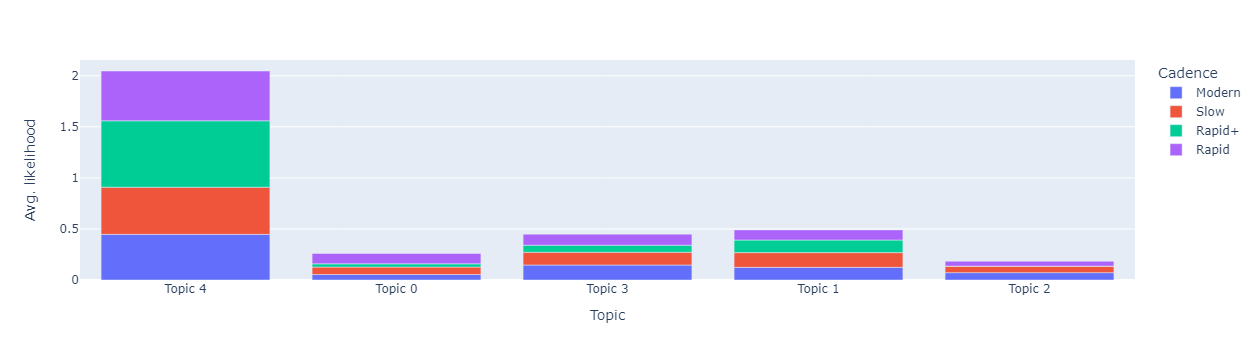

In [161]:
topic_cadence = {f"Topic {topic_id}": {} for topic_id in top_topics}
# topic_cadence = {f"Topic {topic_id}": {} for topic_id in range(model.topics_num_)}

for topic_id in top_topics: # top topics
# for topic_id in range(model.topics_num_): # all topics
    repos_topic_likelihood = repos_topics_classes.copy()
    likelihoods = model.transform(btm.get_vectorized_docs(repos_topic_likelihood["TEXT_PROCESSED"], vocabulary))
    repos_topic_likelihood["TOPIC_LIKELIHOOD"] = likelihoods.T[topic_id]
    
    for cadence in repos_topic_likelihood.CADENCE.unique().tolist():
        cadence_repos = repos_topic_likelihood[repos_topic_likelihood.CADENCE == cadence]
        cadence_likelihood = cadence_repos["TOPIC_LIKELIHOOD"].mean()
        topic_cadence[f"Topic {topic_id}"][cadence.title()] = cadence_likelihood
    
topic_cadence_df = pd.DataFrame([{"Topic": topic_id, "Cadence": k, "Avg. likelihood": v} for topic_id, cadences in topic_cadence.items() for k, v in cadences.items()])
# display(topic_cadence_df)

px.bar(topic_cadence_df, x="Topic", y="Avg. likelihood", color="Cadence").show()

# px.bar(topic_cadence_df, x="Cadence", y="Avg. likelihood", color="Topic").show()
# px.bar(topic_cadence).update_layout(xaxis_title="Cadence", yaxis_title="Topic likelihood").show()

100%|███████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 30469.40it/s]


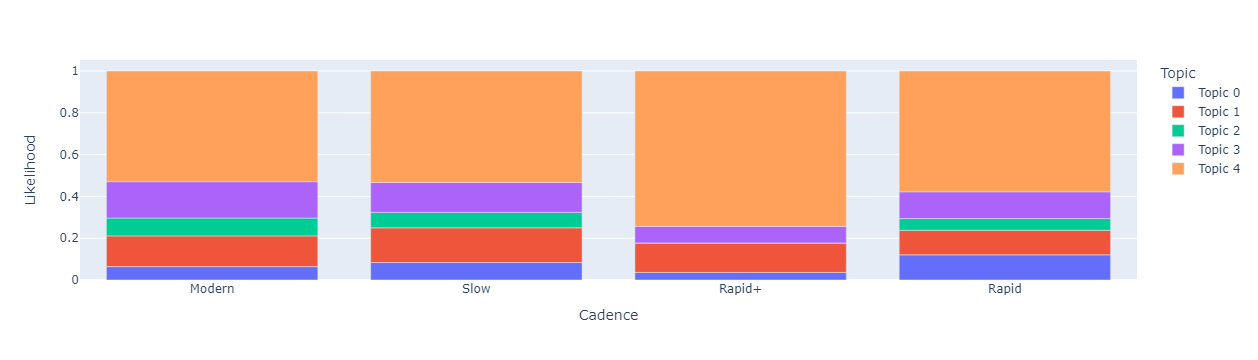

In [162]:
topic_cadence = {}

for cadence in repos_topic_likelihood.CADENCE.unique().tolist():
    topic_cadence[cadence.title()] = {}
    repos_topic_likelihood = repos_topics_classes.copy()
    cadence_repos = repos_topic_likelihood[repos_topic_likelihood.CADENCE == cadence]
    likelihoods = model.transform(btm.get_vectorized_docs(cadence_repos["TEXT_PROCESSED"], vocabulary))
    
    for topic_id in sorted(top_topics): # top topics
    # for topic_id in range(model.topics_num_): # all topics
        topic_likelihood = likelihoods.T[topic_id].sum()  # what is the probability of seeing this topic given the cadence
        topic_cadence[cadence.title()][f"Topic {topic_id}"] = topic_likelihood / likelihoods.sum()
    
topic_cadence_df = pd.DataFrame([{"Topic": k, "Cadence": cadence, "Likelihood": v} for cadence, topics in topic_cadence.items() for k, v in topics.items()])
# display(topic_cadence_df)

# width=600, height=300
fig = px.bar(topic_cadence_df, x="Cadence", y="Likelihood", color="Topic", width=600, height=300) #.update_layout(title_text=f"Topic likelihoods per cadence for {language} projects", title_x=0.5)
fig.show()